## Effective Volume ##

Here, we compute the effective volume and basically re-derive the w2 weight that
enters in the computation of the effective area.

The Monte Carlo file contains reconstructed events, which are a small subset of all the neutrino interactions that were originally generated by the event generator. These a large number ($N_{gen}$) of events was generated in a (huge) volume ($V_{gen}$), where the interacting neutrinos have a power-law spectrum with index $\gamma$. We need to get all these numbers from teh event file's header.

The effective volume is than given by
$$
V_{eff}(E) = V_{gen} \frac{N_{det}(E)}{N_{gen}(E)},
$$

The tricky part is to know $N_{gen}(E)$: the number of events in a given energy bin that was originally generated by genhen. We can compute this number from the information in the header using the nnu function defined below.


In [58]:
ROOT.gStyle.SetOptStat(0)

f = EventFile("../evtfiles/numu_jgandalf.root")
Ngen = float( f.header.get_field("genvol","numberOfEvents") )
Vgen = float( f.header.get_field("genvol","volume") )
gamma= float( f.header.get_line("spectrum"))
Emin, Emax, theta_min, theta_max = (float(x) for x in f.header.get_line("cut_nu").split() )

def nnu(E1, E2):
    "How many neutrinos where generated between E1 and E2?"
    return Ngen *( E2**(1+gamma) - E1**(1+gamma) ) / ( Emax**(1+gamma) - Emin**(1+gamma) )

ttt 0xa4641a0
 EventFile io / wall time = 0.00576591 / 100.515 (0.00573636 % spent on io.)


TFile::Append:0: RuntimeWarning: Replacing existing TH1: hvol (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: hxsec (Potential memory leak).
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c


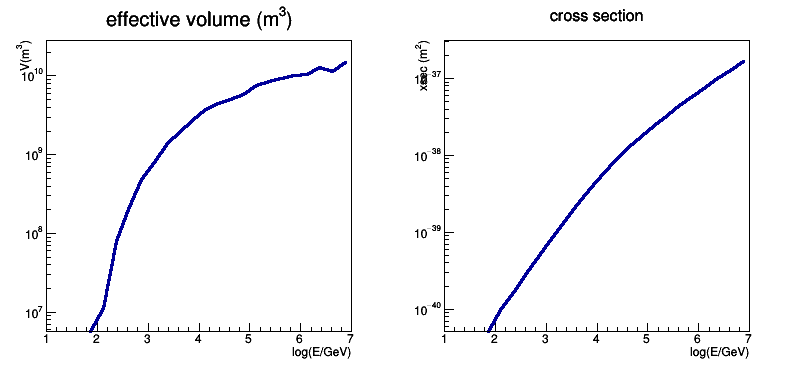

In [128]:
hvol  = TH1D("hvol","effective volume (m^{3});log(E/GeV);V(m^{3})", 24, 1,7 )
hxsec = TH1D("hxsec","cross section;log(E/GeV);xsec (m^{2})", 24, 1,7 )

f.roottree().Draw("log10(mc_trks[0].E)>>hvol" )
f.roottree().Draw("log10(mc_trks[0].E)>>hxsec","w2list[2]") # [2] is the cross-section(Enu)
hxsec.Divide( hvol )

for b in range(1, hvol.GetNbinsX()+1):
    
    "how many neutrinos generated in this bin?"
    e1 = 10**hvol.GetXaxis().GetBinLowEdge(b)
    e2 = 10**hvol.GetXaxis().GetBinUpEdge(b)   
    hvol.SetBinContent( b, hvol.GetBinContent(b) * Vgen / nnu( e1,e2) )

c = ROOT.TCanvas('c','c',800,400)
c.Divide(2,1)
c.cd(1); ROOT.gPad.SetLogy(); hvol.Draw("Lhist")
c.cd(2); ROOT.gPad.SetLogy(); hxsec.Draw("Lhist")
c.Draw()

TFile::Append:0: RuntimeWarning: Replacing existing TH1: haeff2 (Potential memory leak).


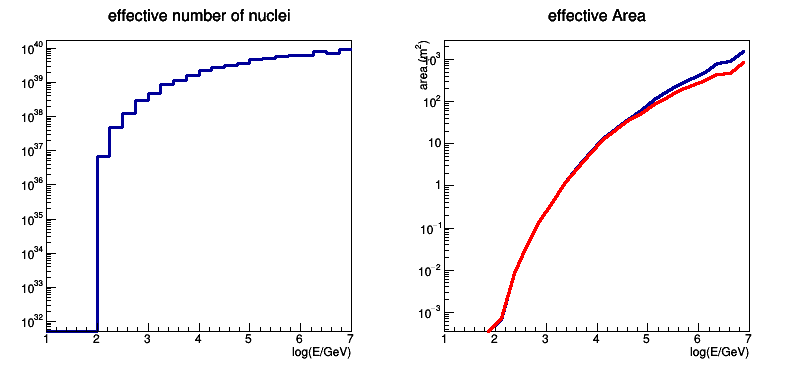

In [127]:
c.cd(1)
hmass = hvol.Clone("hmass")
hmass.SetTitle("effective number of nuclei")
hmass.SetYTitle("")
hmass.Scale(6.022e23 * 1e6 ) # the 10^6 is for gr -> m3 of water
hmass.Draw()

c.cd(2)
haeff = hmass.Clone("haeff")
haeff.SetTitle("effective Area")
haeff.SetYTitle("area (m^{2})")
haeff.Multiply( hxsec )
haeff.Draw("Lhist")

# -- draw the effective area directly from the w2 for comparison --
haeff2  = TH1D("haeff2","effective area", 24, 1,7 )
f.roottree().Draw( "log10(mc_trks[0].E)>>+haeff2","w[1]/mc_trks[0].E" ,"goff")
haeff2.Scale ( 1 / ( ngen * log(10) * haeff.GetBinWidth(1) * 3600.0 * 24 * 365 * 4*pi ))
haeff2.SetLineColor(2)
haeff2.Draw("Lhist same")

c.Draw()



Compare this to the effective area computed directly from the w2 weight: (but note the Earth-survival probability is at this stage not yet included) in the effective volume.

Okay, so the effective volume is basically just the effective area, devided by the cross section and
(depending on how you want to define it) the Earth absorption propbability. So we can plot it in one go like so:

TFile::Append:0: RuntimeWarning: Replacing existing TH1: hv (Potential memory leak).


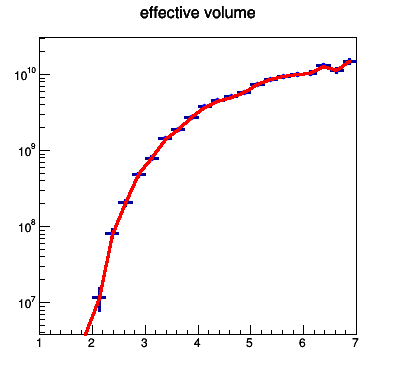

In [99]:
hv  = TH1D("hv","effective volume", 24, 1,7 )
f.roottree().Draw( "log10(mc_trks[0].E)>>hv","w[1]/mc_trks[0].E/w2list[2]/w2list[4]")
hv.Scale( 1 / ( 6.022e23 * 1e6 * ngen * log(10) * hv.GetBinWidth(1) * 3600.0*24*365 * 4*pi ) )

hv.Draw()
hvol.SetLineColor(2)
hvol.Draw("Lhist same")
ROOT.gPad.Draw()
